# Project members: Jacopo Bulgarelli, Ezekiel Sandor
We analyzed a dataset of a Brazilian e-commerce company and performed some queries that could give some useful information to the company. These insights are about customer profiling, time of delivery, most served areas and so on.

In [ ]:
from pyspark.sql.functions import desc
from pyspark.sql.functions import count, col
from pyspark.sql import functions as F

In [ ]:
customers = spark.read.format("csv").option("header", "true").load("/FileStore/tables/olist_customers_dataset.csv")
geos = spark.read.format("csv").option("header", "true").load("/FileStore/tables/olist_geolocation_dataset.csv")
orders = spark.read.format("csv").option("header", "true").load("/FileStore/tables/olist_orders_dataset.csv")
order_items = spark.read.format("csv").option("header", "true").load("/FileStore/tables/olist_order_items_dataset.csv")
products = spark.read.format("csv").option("header", "true").load("/FileStore/tables/olist_products_dataset.csv")


###Question 1###

We are interested in knowing our total sales for each product category. This can help us in determine which are our stronger product categories, which we should keep stocked at all times, but also the weaker categories that we should maybe push harder.

In [ ]:
#1. total sales for each product category
cat_total_sales = order_items.join(orders, orders.order_id == order_items.order_id, 'left').join(products, products.product_id==order_items.product_id, 'left').withColumn('dollarsSold', col('order_item_id')*col('price')).groupBy('product_category_name').agg(F.sum('dollarsSold')).sort(desc('sum(dollarsSold)'))
display(cat_total_sales)

product_category_name sum(dollarsSold) beleza_saude 1347468.4900000044 relogios_presentes 1259634.5800000038 cama_mesa_banho 1228795.4600000102 informatica_acessorios 1135454.6400000013 esporte_lazer 1082435.419999999 moveis_decoracao 929520.9499999918 utilidades_domesticas 750233.7299999902 automotivo 662861.8799999934 cool_stuff 659590.609999994 ferramentas_jardim 584155.0199999944 brinquedos 507961.9599999958 bebes 435699.479999998 perfumaria 419920.0799999989 moveis_escritorio 393017.8300000009 telefonia 360139.72000000253 pcs 247580.05999999997 papelaria 245569.71000000028 pet_shop 237722.39000000007 instrumentos_musicais 200712.37000000026 eletroportateis 198835.1400000001 null 197095.20000000016 eletronicos 179888.86000000118 construcao_ferramentas_construcao 174792.3600000001 fashion_bolsas_e_acessorios 166825.58000000077 consoles_games 164816.68000000028 malas_acessorios 147430.96000000052 telefonia_fixa 128822.79000000001 eletrodomesticos_2 113700.52000000002 casa_construcao 99742.04000000007 agro_industria_e_comercio 91634.76 moveis_sala 87166.25000000007 eletrodomesticos 80332.98000000007 climatizacao 67920.69000000002 casa_conforto 65931.49000000002 moveis_cozinha_area_de_servico_jantar_e_jardim 52588.35 audio 51967.80999999996 construcao_ferramentas_seguranca 50363.12 livros_interesse_geral 50232.79999999995 construcao_ferramentas_iluminacao 49540.039999999986 portateis_casa_forno_e_cafe 48040.70999999999 industria_comercio_e_negocios 43081.75999999999 bebidas 40220.77999999999 sinalizacao_e_seguranca 34797.13 alimentos 33180.449999999946 market_place 32647.12999999998 construcao_ferramentas_jardim 31416.29999999999 artes 25366.08999999999 fashion_calcados 25072.409999999978 moveis_quarto 23167.149999999998 livros_tecnicos 19726.839999999993 alimentos_bebidas 17797.62999999999 construcao_ferramentas_ferramentas 17359.550000000003 fashion_roupa_masculina 12634.409999999998 artigos_de_natal 11372.499999999998 fashion_underwear_e_moda_praia 9931.240000000002 tablets_impressao_imagem 8082.209999999999 cine_foto 7235.760000000002 dvds_blu_ray 6174.060000000002 musica 6059.320000000001 livros_importados 5258.219999999999 artigos_de_festas 4685.780000000001 moveis_colchao_e_estofado 4368.08 portateis_cozinha_e_preparadores_de_alimentos 3986.0600000000004 fashion_roupa_feminina 3438.3699999999994 fashion_esporte 2483.7999999999997 fraldas_higiene 2255.59 la_cuisine 2218.99 pc_gamer 1894.94 artes_e_artesanato 1875.8999999999999 flores 1257.1399999999999 casa_conforto_2 876.37 cds_dvds_musicais 820.0 fashion_roupa_infanto_juvenil 569.85 seguros_e_servicos 283.28999999999996

Let's now create a plot to visualize these informations more effectively

In [ ]:
import pandas as pd
top12 = cat_total_sales.toPandas()
top12 = pd.Series(list(top12['sum(dollarsSold)']), index = list(top12.product_category_name )).sort_values(ascending = False)[0:12]

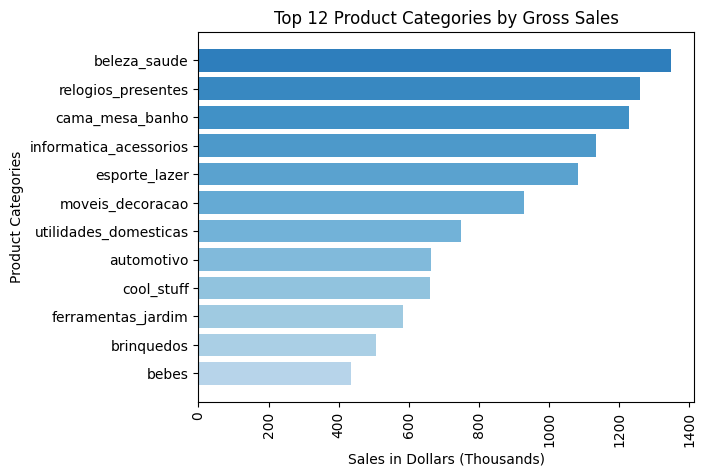

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

dark_blue_colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(top12)))  # Adjust the range for darker shades
dark_blue_cmap = ListedColormap(dark_blue_colors)

plt.barh(top12.index[::-1], [val/1000 for val in list(top12)][::-1], color=dark_blue_cmap.colors)

plt.xticks(rotation=90)
plt.title('Top 12 Product Categories by Gross Sales')
plt.xlabel('Sales in Dollars (Thousands)')
plt.ylabel('Product Categories')
plt.show()


###Question 2

Next we are looking to find the most expensive order that was made in San Paolo. We are doing this to know which is our price "range", since an e-commerce can sell anything from 1$ items to very expensive ones.

In [ ]:
#2. find the most expensive order that was made in san paolo
orders_tmp = order_items.join(orders, orders.order_id == order_items.order_id, 'left').join(customers, customers.customer_id==orders.customer_id, 'left').withColumn('dollarsSold', col('order_item_id')*col('price')).select('dollarsSold',order_items.order_id, customers.customer_city)
san_paolo = orders_tmp.filter(orders_tmp.customer_city=='sao paulo')
san_paolo = san_paolo.groupBy('order_id').agg(F.sum('dollarsSold').alias('dollarsSoldTotal'))
max_value = san_paolo.agg({"dollarsSoldTotal": "max"}).collect()[0][0]
display(san_paolo.filter(san_paolo.dollarsSoldTotal == max_value))

order_id dollarsSoldTotal 1b15974a0141d54e36626dca3fdc731a 21000.0

Now we are creating a table that represents the elapsed time between ordering and delivering time. It will be very useful for the next queries.

In [ ]:
from pyspark.sql.functions import *
orders = orders.withColumn('order_purchase_timestamp',to_timestamp(col('order_purchase_timestamp')))\
.withColumn('order_delivered_customer_date', current_timestamp())\
.withColumn('DiffInMilliseconds',unix_timestamp("order_delivered_customer_date") - unix_timestamp('order_purchase_timestamp'))

In [ ]:
display(orders)

order_id customer_id order_status order_purchase_timestamp order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date DiffInMilliseconds e481f51cbdc54678b7cc49136f2d6af7 9ef432eb6251297304e76186b10a928d delivered 2017-10-02T10:56:33Z 2017-10-02 11:07:15 2017-10-04 19:55:00 2024-02-07T12:17:16.642Z 2017-10-18 00:00:00 200366443 53cdb2fc8bc7dce0b6741e2150273451 b0830fb4747a6c6d20dea0b8c802d7ef delivered 2018-07-24T20:41:37Z 2018-07-26 03:24:27 2018-07-26 14:31:00 2024-02-07T12:17:16.642Z 2018-08-13 00:00:00 174843339 47770eb9100c2d0c44946d9cf07ec65d 41ce2a54c0b03bf3443c3d931a367089 delivered 2018-08-08T08:38:49Z 2018-08-08 08:55:23 2018-08-08 13:50:00 2024-02-07T12:17:16.642Z 2018-09-04 00:00:00 173590707 949d5b44dbf5de918fe9c16f97b45f8a f88197465ea7920adcdbec7375364d82 delivered 2017-11-18T19:28:06Z 2017-11-18 19:45:59 2017-11-22 13:39:59 2024-02-07T12:17:16.642Z 2017-12-15 00:00:00 196274950 ad21c59c0840e6cb83a9ceb5573f8159 8ab97904e6daea8866dbdbc4fb7aad2c delivered 2018-02-13T21:18:39Z 2018-02-13 22:20:29 2018-02-14 19:46:34 2024-02-07T12:17:16.642Z 2018-02-26 00:00:00 188751517 a4591c265e18cb1dcee52889e2d8acc3 503740e9ca751ccdda7ba28e9ab8f608 delivered 2017-07-09T21:57:05Z 2017-07-09 22:10:13 2017-07-11 14:58:04 2024-02-07T12:17:16.642Z 2017-08-01 00:00:00 207670811 136cce7faa42fdb2cefd53fdc79a6098 ed0271e0b7da060a393796590e7b737a invoiced 2017-04-11T12:22:08Z 2017-04-13 13:25:17 null 2024-02-07T12:17:16.642Z 2017-05-09 00:00:00 215394908 6514b8ad8028c9f2cc2374ded245783f 9bdf08b4b3b52b5526ff42d37d47f222 delivered 2017-05-16T13:10:30Z 2017-05-16 13:22:11 2017-05-22 10:07:46 2024-02-07T12:17:16.642Z 2017-06-07 00:00:00 212368006 76c6e866289321a7c93b82b54852dc33 f54a9f0e6b351c431402b8461ea51999 delivered 2017-01-23T18:29:09Z 2017-01-25 02:50:47 2017-01-26 14:16:31 2024-02-07T12:17:16.642Z 2017-03-06 00:00:00 222112087 e69bfb5eb88e0ed6a785585b27e16dbf 31ad1d1b63eb9962463f764d4e6e0c9d delivered 2017-07-29T11:55:02Z 2017-07-29 12:05:32 2017-08-10 19:45:24 2024-02-07T12:17:16.642Z 2017-08-23 00:00:00 205978934 e6ce16cb79ec1d90b1da9085a6118aeb 494dded5b201313c64ed7f100595b95c delivered 2017-05-16T19:41:10Z 2017-05-16 19:50:18 2017-05-18 11:40:40 2024-02-07T12:17:16.642Z 2017-06-07 00:00:00 212344566 34513ce0c4fab462a55830c0989c7edb 7711cf624183d843aafe81855097bc37 delivered 2017-07-13T19:58:11Z 2017-07-13 20:10:08 2017-07-14 18:43:29 2024-02-07T12:17:16.642Z 2017-08-08 00:00:00 207332345 82566a660a982b15fb86e904c8d32918 d3e3b74c766bc6214e0c830b17ee2341 delivered 2018-06-07T10:06:19Z 2018-06-09 03:13:12 2018-06-11 13:29:00 2024-02-07T12:17:16.642Z 2018-07-18 00:00:00 178942257 5ff96c15d0b717ac6ad1f3d77225a350 19402a48fe860416adf93348aba37740 delivered 2018-07-25T17:44:10Z 2018-07-25 17:55:14 2018-07-26 13:16:00 2024-02-07T12:17:16.642Z 2018-08-08 00:00:00 174767586 432aaf21d85167c2c86ec9448c4e42cc 3df704f53d3f1d4818840b34ec672a9f delivered 2018-03-01T14:14:28Z 2018-03-01 15:10:47 2018-03-02 21:09:20 2024-02-07T12:17:16.642Z 2018-03-21 00:00:00 187394568 dcb36b511fcac050b97cd5c05de84dc3 3b6828a50ffe546942b7a473d70ac0fc delivered 2018-06-07T19:03:12Z 2018-06-12 23:31:02 2018-06-11 14:54:00 2024-02-07T12:17:16.642Z 2018-07-04 00:00:00 178910044 403b97836b0c04a622354cf531062e5f 738b086814c6fcc74b8cc583f8516ee3 delivered 2018-01-02T19:00:43Z 2018-01-02 19:09:04 2018-01-03 18:19:09 2024-02-07T12:17:16.642Z 2018-02-06 00:00:00 192388593 116f0b09343b49556bbad5f35bee0cdf 3187789bec990987628d7a9beb4dd6ac delivered 2017-12-26T23:41:31Z 2017-12-26 23:50:22 2017-12-28 18:33:05 2024-02-07T12:17:16.642Z 2018-01-29 00:00:00 192976545 85ce859fd6dc634de8d2f1e290444043 059f7fc5719c7da6cbafe370971a8d70 delivered 2017-11-21T00:03:41Z 2017-11-21 00:14:22 2017-11-23 21:32:26 2024-02-07T12:17:16.642Z 2017-12-11 00:00:00 196085615 83018ec114eee8641c97e08f7b4e926f 7f8c8b9c2ae27bf3300f670c3d478be8 delivered 2017-10-26T15:54:26Z 2017-10-26 16:08:14 2017-10-26 21:46:53 2024-02-07T12:17:16.642Z 2017-11-23 00:00:00 1

###Question 3

Amazon has made 2 day delivery an industry standard, so in order to see how we stack up against them lets see how many of our orders are shipped in under 48 hours from purchase time. In this way we will bw able to see how much improvement is needed.

In [ ]:
#3 find how many of our orders are shipped in under 48 hours from purchase time
orders2days = orders.filter(orders.DiffInMilliseconds < (1000*60*60*24*2))
display(orders2days.count())
display(orders.count())

1680

99441

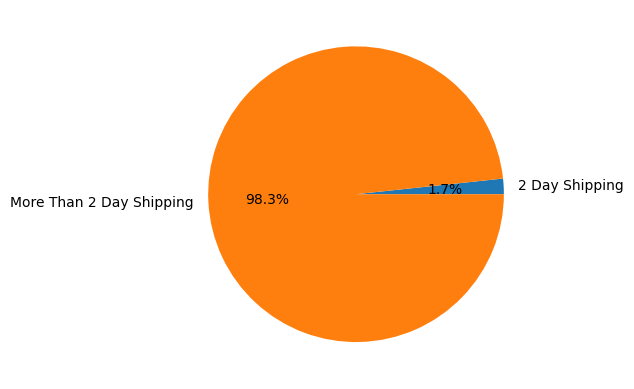

In [ ]:
labels = []
fig, ax = plt.subplots()
ax.pie([orders2days.count(), orders.count() - orders2days.count()], labels=['2 Day Shipping','More Than 2 Day Shipping'],autopct='%1.1f%%')

plt.show()

Let's also see how many deliveries are in less then 3 days

In [ ]:
#3.2 let's now see how many deliveries are in less then 3 days
orders3days = orders.filter(orders.DiffInMilliseconds < (1000*60*60*24*3))
display(orders3days.count())
display(orders.count())
print('Our percentage of orders that are completed within 3 days is ' +str(orders3days.count()/orders.count() * 100) +'%')

99441

99441

Our percentage of orders that are completed within 3 days is 100.0%


So, only the 2% of our deliveries are in less than 2 days but the 100% is under 3 days, not too bad.

### Question 4

Now we want to see what is our average and median time to delivery from purchase time, to understand if it's closer to 48 or 72 hours. We then will represent this distribution with a boxplot.

In [ ]:
#4. what is our average and median time to delivery from purchase time
orders.describe(['DiffInMilliseconds']).show()

+-------+--------------------+
|summary|  DiffInMilliseconds|
+-------+--------------------+
|  count|               99441|
|   mean|1.9262098822341892E8|
| stddev|1.3277018785401022E7|
|    min|           167533363|
|    max|           234307062|
+-------+--------------------+



In [ ]:
np.min(x)

46.53758194444445

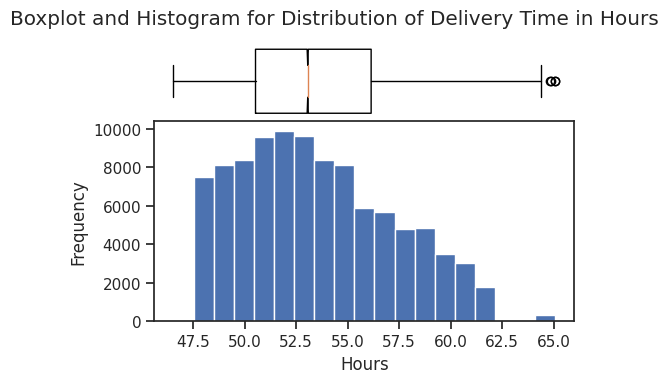

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# fake data
x = np.array((orders.select('DiffInMilliseconds').toPandas()/(1000*60*60))).reshape(1,-1)[0]

# setup the figure and axes
fig = plt.figure(figsize=(6,4))
bpAx = fig.add_axes([0.2, 0.7, 0.7, 0.2])   # left, bottom, width, height:
                                            # (adjust as necessary)
histAx = fig.add_axes([0.2, 0.2, 0.7, 0.5]) # left specs should match and
                                            # bottom + height on this line should
                                            # equal bottom on bpAx line
# plot stuff
bp = bpAx.boxplot(x, notch=True, vert=False, widths= (0.8))
h = histAx.hist(x, bins=int(int(np.max(x))-int(np.min(x))))

# confirm that the axes line up
xlims = np.array([bpAx.get_xlim(), histAx.get_xlim()])
for ax in [bpAx, histAx]:
    ax.set_xlim([xlims.min(), xlims.max()])

bpAx.spines['top'].set_visible(False)
bpAx.spines['right'].set_visible(False)
bpAx.spines['bottom'].set_visible(False)
bpAx.spines['left'].set_visible(False)

bpAx.set_xticklabels([])  # clear out overlapping xlabels
bpAx.set_yticks([])  # don't need that 1 tick mark
fig.suptitle('Boxplot and Histogram for Distribution of Delivery Time in Hours')
plt.xlabel('Hours')
histAx.set_ylabel('Frequency')
plt.show()

### Question 5

Now we want to know on average what our distrubtion of delivery times is by each city that we deliver to in order to identify possible weak points in our ability to deliver products.

In [ ]:
#5. what our distrubtion of delivery times is by each city that we deliver to
from pyspark.sql import functions as F
cust_orders = orders.join(customers, customers.customer_id==orders.customer_id, 'left').select(customers.customer_city, orders.DiffInMilliseconds )
avgdeliverytimes = cust_orders.groupBy('customer_city').agg(F.mean('DiffInMilliseconds')).sort(desc('avg(DiffInMilliseconds)'))
avgdeliverytimes = avgdeliverytimes.withColumn('DiffInHours',round(col('avg(DiffInMilliseconds)')/3600000))
display(avgdeliverytimes)

customer_city avg(DiffInMilliseconds) DiffInHours bacaxa 2.31723379E8 64.0 cacimbinhas 2.31500909E8 64.0 apuarema 2.31392122E8 64.0 vargem 2.269529565E8 63.0 sao joao do itaperiu 2.23183147E8 62.0 boa vista das missoes 2.22652403E8 62.0 sete de setembro 2.22411898E8 62.0 faxinalzinho 2.22134903E8 62.0 tres irmaos 2.22133247E8 62.0 cha grande 2.22053288E8 62.0 sao pedro da agua branca 2.21909155E8 62.0 godoy moreira 2.21370706E8 61.0 ajapi 2.21350528E8 61.0 garruchos 2.21348575E8 61.0 amarante 2.21119691E8 61.0 palmeira d oeste 2.21059089E8 61.0 ibipeba 2.21021755E8 61.0 iretama 2.20916783E8 61.0 palmares paulista 2.20855596E8 61.0 sao luiz do norte 2.20851667E8 61.0 pedro gomes 2.20832203E8 61.0 canaa 2.20790816E8 61.0 sao bras 2.20747959E8 61.0 sao joao do sabugi 2.2074793E8 61.0 central 2.20740793E8 61.0 nova independencia 2.20725227E8 61.0 mariano moro 2.20690911E8 61.0 santana do capivari 2.20672816E8 61.0 capitao eneas 2.20610125E8 61.0 coite do noia 2.20493044E8 61.0 guape 2.20476996E8 61.0 senhora dos remedios 2.20266988E8 61.0 francisco santos 2.20220858E8 61.0 ourizona 2.20139248E8 61.0 nova lacerda 2.20077618E8 61.0 livramento 2.20056084E8 61.0 brasileia 2.19907399E8 61.0 santo antonio do taua 2.19902898E8 61.0 bugre 2.19732403E8 61.0 prudencio thomaz 2.1973039E8 61.0 itatiba do sul 2.19704314E8 61.0 jardim de piranhas 2.19545321E8 61.0 gramado xavier 2.19538401E8 61.0 dezesseis de novembro 2.19486646E8 61.0 arara 2.19321869E8 61.0 florania 2.19093414E8 61.0 divinopolis do tocantins 2.19045511E8 61.0 jaua 2.18884573E8 61.0 pratapolis 2.18877947E8 61.0 tracunhaem 2.188084245E8 61.0 ibitita 2.18780687E8 61.0 paial 2.18680984E8 61.0 apora 2.18600851E8 61.0 retirolandia 2.18577154E8 61.0 rio espera 2.18515344E8 61.0 pirapemas 2.18403274E8 61.0 frei gaspar 2.18274908E8 61.0 ibimirim 2.1804545E8 61.0 fontoura xavier 2.17985968E8 61.0 desterro do melo 2.17920815E8 61.0 boraceia 2.1790221E8 61.0 bela vista de minas 2.17888662E8 61.0 tavares 2.17799568E8 60.0 campos verdes 2.1771E8 60.0 alianca 2.17668184E8 60.0 neopolis 2.17653639E8 60.0 cordeiros 2.17580419E8 60.0 mira estrela 2.17365701E8 60.0 filadelfia 2.17311422E8 60.0 francisco dantas 2.17289778E8 60.0 humildes 2.17288408E8 60.0 fagundes 2.17270944E8 60.0 jaquirana 2.17238522E8 60.0 palmital de minas 2.17203438E8 60.0 nova santa barbara 2.17113965E8 60.0 vicentinopolis 2.170685745E8 60.0 guiricema 2.17066619E8 60.0 angelina 2.17049235E8 60.0 ceilandia 2.17031945E8 60.0 santa isabel do rio preto 2.16963291E8 60.0 japoata 2.16892768E8 60.0 miradouro 2.16861869E8 60.0 vargem grande do rio pardo 2.16803376E8 60.0 erebango 2.16722096E8 60.0 santo antonio de goias 2.16717389E8 60.0 rio grande do piaui 2.16687918E8 60.0 fragosos 2.16644925E8 60.0 buriti 2.16639069E8 60.0 pavao 2.16629056E8 60.0 passagem franca 2.16610015E8 60.0 caxingo 2.16457092E8 60.0 nossa senhora da gloria 2.164564215E8 60.0 nova floresta 2.16445892E8 60.0 pianco 2.1633463E8 60.0 indiaroba 2.16329731E8 60.0 moreilandia 2.163028185E8 60.0 coronel sapucaia 2.16266117E8 60.0 juranda 2.16248635E8 60.0 cubati 2.16241978E8 60.0 murucupi 2.16101153E8 60.0 mogi-mirim 2.160221645E8 60.0 tamandare 2.1599246E8 60.0 vicosa do ceara 2.15981129E8 60.0 morro redondo 2.15947418E8 60.0 euclides da cunha paulista 2.15772697E8 60.0 carnaubal 2.15611965E8 60.0 lajeado grande 2.15550636E8 60.0 macieira 2.15509289E8 60.0 campo alegre de lourdes 2.15499886E8 60.0 pescador 2.15490355E8 60.0 tapera 2.15469769E8 60.0 alfredo vasconcelos 2.1546217333333334E8 60.0 embu 2.1543778945454547E8 60.0 conceicao do almeida 2.15416945E8 60.0 morro da garca 2.15396892E8 60.0 buriti do tocantins 2.15336103E8 60.0 cristais paulista 2.1529944625E8 60.0 pires ferreira 2.15245937E8 60.0 morro agudo de goias 2.15197927E8 60.0 sao benedito do sul 2.15057648E8 60.0 santo antonio do caiua 2.14970559E8 60.0 abdon batista 2.14819924E8 60.0 balsa nova 2.14743028E8 60.0 brasopolis 2.14730243E8 60.0 dores de guanhaes 2.14726802E8 60.0 itabirinha 2.14726083

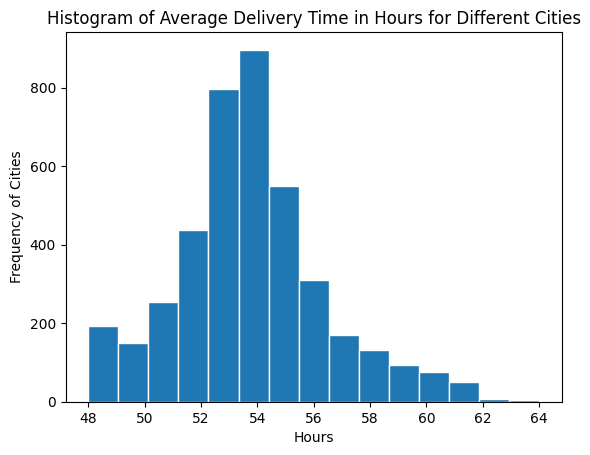

In [ ]:
#produce a histogram and bar chart here
#####
import matplotlib.pyplot as plt

plt.hist(avgdeliverytimes.toPandas()['DiffInHours'], edgecolor='white', bins=15)
plt.title('Histogram of Average Delivery Time in Hours for Different Cities')
plt.xlabel('Hours')
plt.ylabel('Frequency of Cities')
plt.show()


We can see that the delta is not too big, in fact between the slowest and fastest result the difference is 16 hours.

In combination with the previous chart that we looked at, we can see that while for most of our cities the difference in delivery time evens out, we in fact do have particular cities where the average delivery time is lagging behind.

### Question 6
Lets get an understanding of what our sales look like for each month in order to know wheter our revenue stream follows a seasonality or is stable.

In [ ]:
#6. lets get an understanding of what our sales look like for each month

from pyspark.sql.functions import year, month, dayofmonth

order_months = orders.withColumn('order_purchase_timestamp', to_timestamp(col('order_purchase_timestamp'))).withColumn('order_month', month(col('order_purchase_timestamp')))
monthly_sales = order_months.groupBy('order_month').count()

In [ ]:
sales_by_month = monthly_sales.toPandas()
sales_by_month = pd.Series(list(sales_by_month['count']),index = list(sales_by_month.order_month))

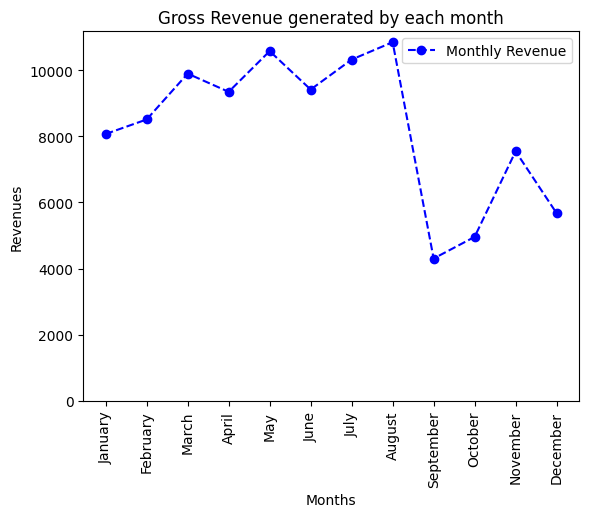

In [ ]:
import matplotlib.pyplot as plt

# Plotting sales data by month
sales_by_month = sales_by_month.sort_index()
plt.title('Gross Revenue generated by each month')
plt.plot(sales_by_month, linestyle='--', marker='o', color='b', label='Monthly Revenue')
plt.legend()
plt.xticks(list(sales_by_month.index), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation='vertical')

plt.xlabel('Months')
plt.ylabel('Revenues')

# Setting y-axis limit to start from 0
plt.ylim(bottom=0)

plt.show()


We can notice a big drop between August and September, and lower sales in the winter season in general.

### Question 7
Now we are looking for the number of orders we got for each state.

In [ ]:
#7. number of orders we got for each state
state_order_counts = orders.join(customers, orders.customer_id == customers.customer_id,'left').select('customer_state').groupBy('customer_state').count()

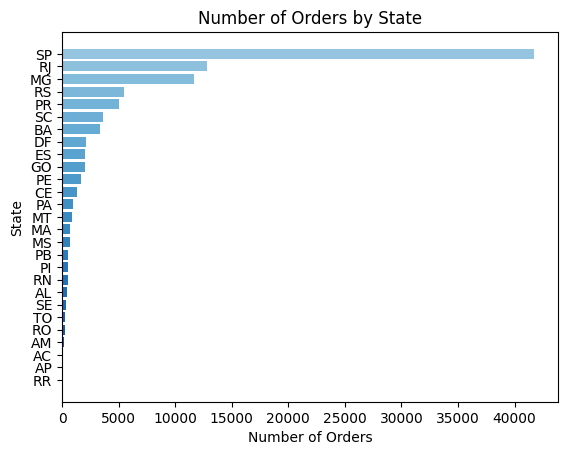

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sorting the dataframe by 'count' column in descending order
state_order_counts = state_order_counts.sort_values(by='count', ascending=False)

# Generate colors using the Blues colormap
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(state_order_counts)))

# Create a horizontal bar chart
plt.barh(state_order_counts['customer_state'], state_order_counts['count'], color=colors)

# Invert y-axis to display bars in descending order
plt.gca().invert_yaxis()

plt.title('Number of Orders by State')
plt.xlabel('Number of Orders')
plt.ylabel('State')
plt.show()

We can see that the Sao Paolo state is by far the most important for us, but it makes sense because is the most populated state in Brasil.

### Question 8
on average what does each customer spend?

In [ ]:
# 8. on average what does each customer spend?
display(order_items.join(orders, orders.order_id == order_items.order_id, 'left').withColumn('dollarsSold', col('order_item_id')*col('price')).groupBy('customer_id').agg(F.sum('dollarsSold').alias('sumDollars')).agg({'sumDollars':'avg'}))

avg(sumDollars) 156.05921604200262